In [80]:
import pandas as pd
import pickle
import numpy as np
import dataloader
import torch
import torchvision
import cv2
import matplotlib.pyplot as plt
import metrics

In [81]:
DATASETS = ['Adobe240', 'UCF101', 'Vimeo90k']
METHODS = ['DAIN', 'SepConv', 'QVI', 'QVI_linear']
METRICS = ['psnr', 'ssim', 'ie']

## Metrics

The following metrics are reported in the benchmark, for a predicted and ground truth image frame $\hat{I}$ and $I$ respectively:

\begin{equation}
    \mathrm{SSIM}(\hat{I}, I) = 
    \frac{2 \mu_{\hat{I}} \mu_I + C_1}{\mu^2_{\hat{I}} + \mu^2_I+C_1}
    \frac{2 \sigma_{\hat{I}} \sigma_I + C_2}{\sigma^2_{\hat{I}}+\sigma_I^2+C_2}
    \frac{2 \sigma^2_{\hat{I}} + C_3}{\sigma_{\hat{I}} \sigma_I^2 + C_3}
\end{equation}

$$\mathrm{PSNR}(\hat{I}, I) = 10 \, \log_{10} \left(\frac{R^2}{||\hat{I}-I||_2} \right)$$

$$\mathrm{IE}(\hat{I}, I) = \left( 
    \frac{1}{N} \sum_x (\hat{I}_x - I_x)^2
    \right)^{1/2}$$

## Datasets

### Middlebury benchmark

Baker et al. https://ps.is.mpg.de/publications/baker-ijcv-11

This is the standard benchmarking dataset for frame interpolation. Aside from the publicly available test set, they also host an online evaluation system where you can submit predicted interpolated frames. The website will then calculate the metrics serverside. This ensures that the results are obtained honestly.

Their work is an advancement on the earlier work of Barron et al. (https://link.springer.com/article/10.1007/BF01420984 ). The resulting dataset consists of more natural and complex scenes, making it possible to use it as a real word benchmark. It does only consist of a small set of images, so it is only useful for evaluation, not for training.

### UCF101

Soomro et al. https://arxiv.org/abs/1212.0402

This dataset focusses on video clips containing 'actions'. The dataset covers 101 action classes, covering applying make up, surfing and shaving. Their work is an extension of the earlier UCF50 dataset, which contained only 50 action classes (https://www.crcv.ucf.edu/research/recognizing-50-human-action-categories-of-web-videos/ ). The authors claim that the dataset is challenging, because of its wide variety of content, and because of the changing lighting conditions and low frame rate. Despite the fact that the dataset is originally used to build models to classify the action present in the video, it is also often used for video frame interpolation.

### Vimeo90K

Xue et al. https://arxiv.org/abs/1711.09078

The Vimeo90K dataset, named after the nearly 90.000 video sequences extracted from the original videos from Vimeo, is does not comprise of videos, but is actually already preprocessed and extracted into frames directly usable for the video frame interpolation task. Each frame sequence consists of seven consecutive frames, and each frame has a resolution of $256\times 448$. This dataset is one of the first high quality benchmarking data sets for video frame interpolation, since the original videos were all originally 720p or of higher quality. To standardize the dataset, all videos were downsampled to $256\times 448$.

### Adobe240

Su et al. https://www.cs.ubc.ca/labs/imager/tr/2017/DeepVideoDeblurring/

The Adobe240 dataset contains 133 high-quality 720p videos, i.e. having a frame size of $720 \times 1280$. The dataset is named after its frame rate, all of these videos are recorded in 240 frames per second. The authors created this datases because they needed to create a method for deblurring videos on high frame rate video data. They recorded the videos themselves using a variety of devices, decreasing the bias towards one of the cameras and improve the generalizability.

## Benchmark

In [82]:
with open('results_new2.pkl', 'rb') as f:
    r = pickle.load(f)

df = pd.DataFrame()

for dataset in DATASETS:
    for metric in METRICS:
        df[f'{dataset}_{metric}'] = [np.mean(r[mtd][dataset][metric]) for mtd in methods]

df.index = METHODS
df

,Adobe240_psnr,Adobe240_ssim,Adobe240_ie,UCF101_psnr,UCF101_ssim,UCF101_ie,Vimeo90k_psnr,Vimeo90k_ssim,Vimeo90k_ie
DAIN,31.961128,0.987827,7.143956,28.029401,0.989354,10.767213,34.529848,0.997281,4.786827
SepConv,35.989532,0.991460,4.825874,35.711397,0.996307,5.278466,35.459229,0.997804,4.301092
QVI,34.418327,0.987929,5.972139,35.837244,0.996491,5.101878,37.132111,0.998507,3.547599
QVI_linear,34.891606,0.991942,5.217119,35.255868,0.996512,5.299390,36.842876,0.998404,3.667721


## Qualitative results

In [83]:
video, _, _ = torchvision.io.read_video('rai_slide_lq.mp4')

In [84]:
start_frame = 270
frame_indices = [start_frame + i for i in range(5)]
frames = video[frame_indices, :, :, :]

In [85]:
frames.shape

torch.Size([5, 480, 640, 3])

In [86]:
input_frames = frames[[0,1,3,4], :, :, :]
input_frames = list(input_frames.unbind())
gt_frame = frames[2, :, :, :]

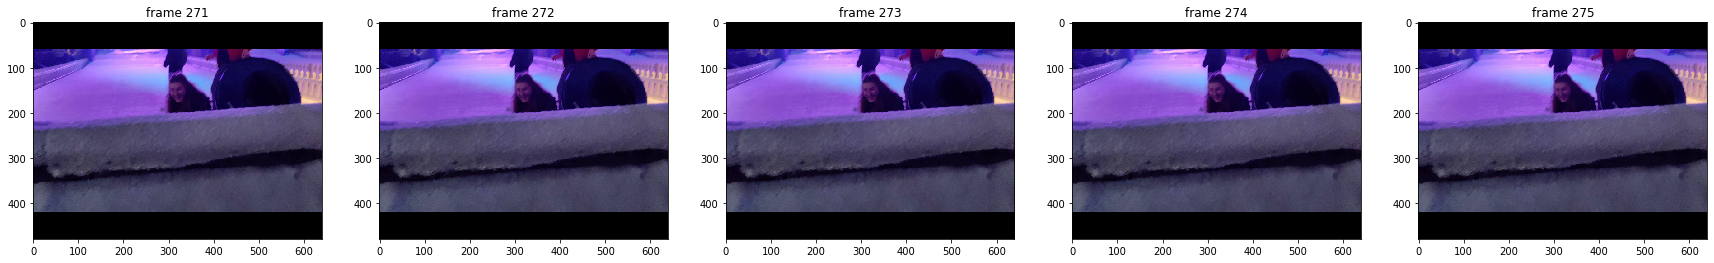

In [87]:
## plot input and ground truth (middle image)
f, ax = plt.subplots(1,5, figsize=(30,16))
for i in range(5):
    ax[i].imshow(frames[i].numpy())
    ax[i].set_title(f'frame {i+start_frame+1}')

plt.show()

### QVI

In [98]:
from code.quadratic.interpolate import interpolate as qvi_interpolate
from code.sepconv.interpolate import interpolate as sepconv_interpolate
from code.DAIN.interpolate import interpolate_efficient as dain_interpolate

In [99]:
qvi_int = qvi_interpolate(input_frames, t=0.5)
qvi_psnr = metrics.psnr(qvi_int.permute(2,0,1).unsqueeze(0), gt_frame.permute(2,0,1).unsqueeze(0)).item()

c:\users\ruth\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
c:\users\ruth\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [106]:
qvi_int_lin = qvi_interpolate(input_frames[1:3], t=0.5)
qvi_lin_psnr = metrics.psnr(qvi_int_lin.permute(2,0,1).unsqueeze(0), gt_frame.permute(2,0,1).unsqueeze(0)).item()

c:\users\ruth\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2693: UserWarning: Default grid_sample and affine_grid behavior will be changed to align_corners=False from 1.4.0. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior will be changed "
c:\users\ruth\appdata\local\programs\python\python37\lib\site-packages\torch\nn\functional.py:2494: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [107]:
sepconv_int = sepconv_interpolate(input_frames[1:3])
sepconv_psnr = metrics.psnr(sepconv_int.permute(2,0,1).unsqueeze(0), gt_frame.permute(2,0,1).unsqueeze(0)).item()

In [108]:
dain_int = dain_interpolate(input_frames[1:3])
dain_psnr = metrics.psnr(torch.from_numpy(dain_int).permute(2,0,1).unsqueeze(0), gt_frame.permute(2,0,1).unsqueeze(0)).item()

Text(0.5, 1.0, 'DAIN, PSNR: 32.45530700683594')

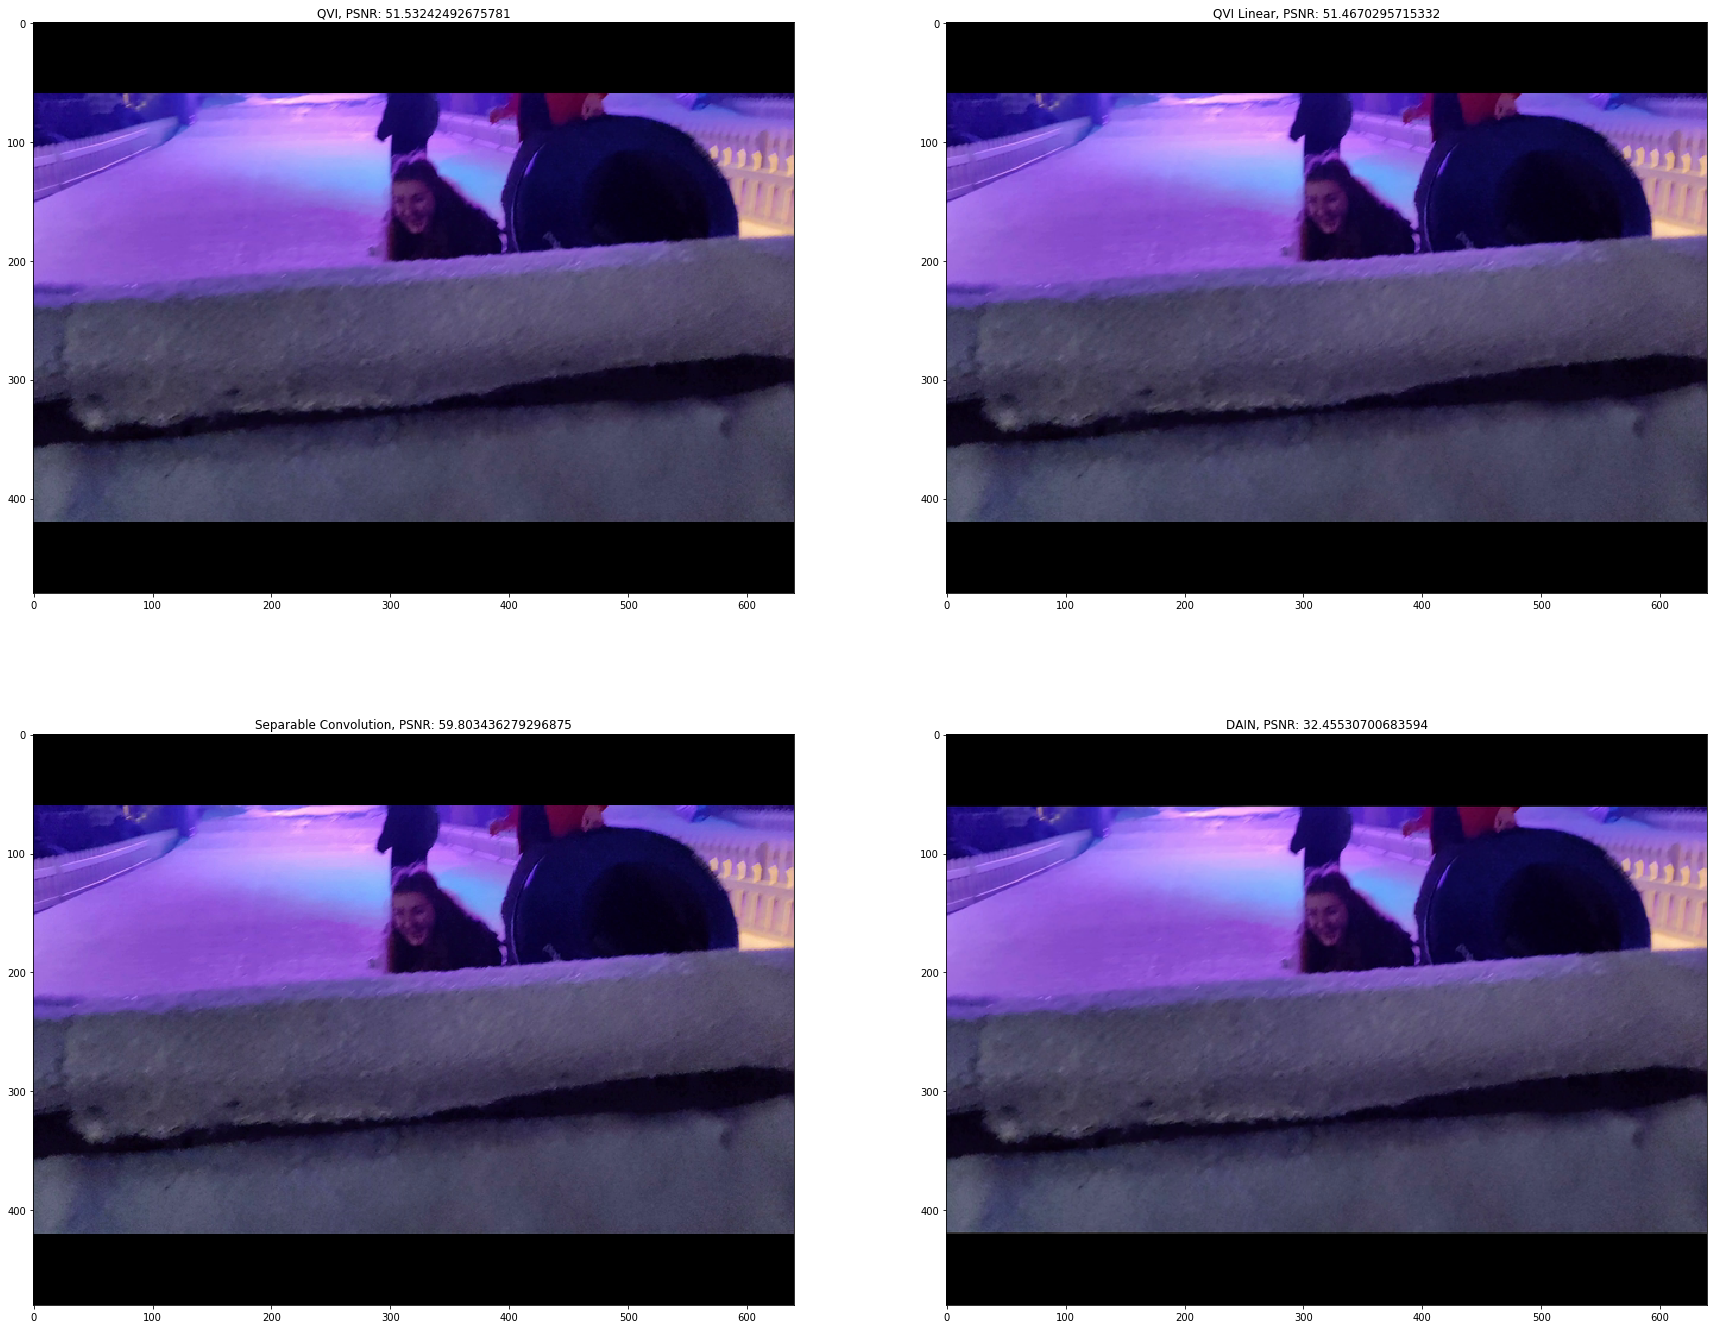

In [109]:
f, ax = plt.subplots(2,2, figsize=(30,24))
ax[0,0].imshow(qvi_int.numpy().astype(int))
ax[0,0].set_title(f'QVI, PSNR: {qvi_psnr}')

ax[0,1].imshow(qvi_int_lin.numpy().astype(int))
ax[0,1].set_title(f'QVI Linear, PSNR: {qvi_lin_psnr}')

ax[1,0].imshow(sepconv_int.numpy().astype(int))
ax[1,0].set_title(f'Separable Convolution, PSNR: {sepconv_psnr}')

ax[1,1].imshow(dain_int.astype(int))
ax[1,1].set_title(f'DAIN, PSNR: {dain_psnr}')